## Pixel CNN 

Alternative approach to Pixel RNN from [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf). 
You can find many online resources to this topic - this notebook is based on the following resources:
 * See for an existing PyTorch implementation https://github.com/jzbontar/pixelcnn-pytorch/blob/master/main.py
 * http://sergeiturukin.com/2017/02/22/pixelcnn.html for a nice walk-through
 * http://tinyclouds.org/residency/
 * https://github.com/pilipolio/learn-pytorch

The core idea of this [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model) is the following:

### Joint distribution of an image $\mathbf{x}$ modelled as an autoregressive process

Same model for PixelRNN and PixelCNN:

$$p(\mathbf{x}) = \prod_{i=1}^{n^2} p(x_i|x_{1}, \dots, x_{i-1})$$
 
![](http://sergeiturukin.com/assets/2017-02-22-183010_479x494_scrot.png)

That means you model the dependencies so that the first pixel is independent, the second depends on first, third depends on first and second and so on. The image is modelled as a sequence of points comparable to a time series where each point depends linearly on previous ones.

The consequence of this idea is that the generation is performed sequentially: one generates the first pixel with one forward pass, then generates the second one given the first and continue the process until you have whole image generated. That is in contrast with convolutional neural network where the whole process is sort of parallel (kernel working on an image).


In [2]:
import numpy as np
from matplotlib import pyplot as plt

def show_as_image(binary_image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(binary_image, cmap='gray')
    plt.xticks([]); plt.yticks([])

%matplotlib inline

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, utils
from torch.autograd import Variable

## Causal or masked convolutions

Masks in a kernel are a way to restrict the information flow from 'future' pixels into the one we’re predicting. 
One way  is to use masked convolutions: all we need is just zero out some weights in convolution filters, like illustrated in the image. One can see, that information from pixels below won’t reach the target (center) pixel as well as from pixels on the same line to the right of target.

![](http://sergeiturukin.com/assets/filter_mask5x5.png)

There are two different modes of masking:
   * Type B: includes the center pixel
   * Type A: excludes the center pixel

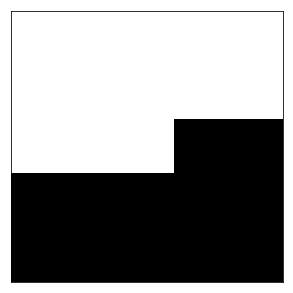

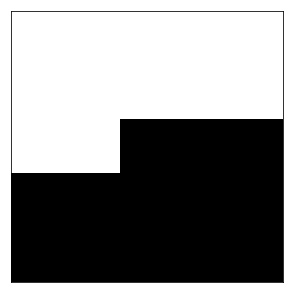

In [5]:
def causal_mask(width, height, starting_point):
    row_grid, col_grid = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
    mask = np.logical_or(
        row_grid < starting_point[0],
        np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))
    return mask

def conv_mask(width, height, include_center=False):
    return 1.0 * causal_mask(width, height, starting_point=(width//2, height//2 + include_center - 1))

show_as_image(conv_mask(5, 5, include_center=True))

show_as_image(conv_mask(5, 5, include_center=False))

## Zero-ing all inputs weights after center point

In [7]:
out_channels, in_channels, width, height = 2, 2, 3, 3

conv_weights = 1 + np.arange(out_channels * in_channels * width * height).reshape((out_channels, in_channels, width, height))

print(conv_mask)

masked_weights = conv_weights * conv_mask(width, height, False)

masked_weights


<function conv_mask at 0x11b78e488>


array([[[[ 1.,  2.,  3.],
         [ 4.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[10., 11., 12.],
         [13.,  0.,  0.],
         [ 0.,  0.,  0.]]],


       [[[19., 20., 21.],
         [22.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[28., 29., 30.],
         [31.,  0.,  0.],
         [ 0.,  0.,  0.]]]])

In [8]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        _, n_channels, width, height = self.weight.size()

        mask = conv_mask(width, height, include_center=mask_type=='B')
        self.register_buffer('mask', torch.from_numpy(mask).float())

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

### Fully convolutional network preserving spatial resolution

Input to output map      |  Output distribution
:-------------------------:|:-------------------------:
![](https://tensorflowkorea.files.wordpress.com/2016/11/pixel-cnn1.png)  |  ![](http://tinyclouds.org/residency/pixelcnn.png)

Quite a counter-intuitive model:

 * Convolutional layers bottom to top!
 * Last layer with `kernel_size=1` and outputs $ n_W \times n_H \times n_{pixels}$ logits, inferring $p(\mathbf{x})$ in one forward pass (during training)
 * Representation of dimension `n_channels` output by each layer anologous to RNN's internal state vector $\mathbf{h}$
 * Necessary to stack enough layers (and/or dillatations) to augment the "receptive field" so that output pixels can be influenced by the whole image
 

Below is a minimalistic implementation for 0/1 pixels without many of the bells and whistles of the original paper:

In [10]:
class PixelCNN(nn.Module):
    n_channels = 4
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels
    
    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )
        
    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

## Application on a simple generative model of LCD digits

From https://gist.github.com/benjaminwilson/b25a321f292f98d74269b83d4ed2b9a8#file-lcd-digits-dataset-nmf-ipynb

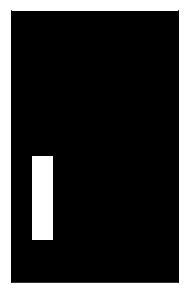

In [12]:
cell_length = 4
image_width, image_height = 2 * cell_length + 5, cell_length + 4

def vertical_stroke(rightness, downness):
    """
    Return a 2d numpy array representing an image with a single vertical stroke in it.
    `rightness` and `downness` are values from [0, 1] and define the position of the vertical stroke.
    """
    i = (downness * (cell_length + 1)) + 2
    j = rightness * (cell_length + 1) + 1
    x = np.zeros(shape=(image_width, image_height), dtype=np.float64)
    x[i + np.arange(cell_length), j] = 1.
    return x

def horizontal_stroke(downness):
    """
    Analogue to vertical_stroke, but it returns horizontal strokes.
    `downness` is here a value in [0, 1, 2].
    """
    i = (downness * (cell_length + 1)) + 1
    x = np.zeros(shape=(image_width, image_height), dtype=np.float64)
    x[i, 2 + np.arange(cell_length)] = 1.
    return x

show_as_image(vertical_stroke(0,1))

output array for number '5':  [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


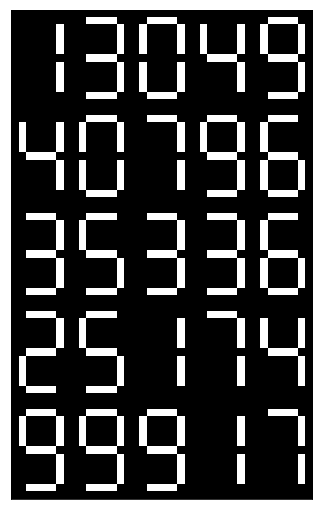

In [26]:
BASE_STROKES = np.asarray(
    [horizontal_stroke(k) for k in range(3)] + [vertical_stroke(k, l) for k in range(2) for l in range(2)])

DIGITS_STROKES = np.array([[0, 2, 3, 4, 5, 6], [5, 6], [0, 1, 2, 4, 5], [0, 1, 2, 5, 6], [1, 3, 5, 6], [0, 1, 2, 3, 6], [0, 1, 2, 3, 4, 6], [0, 5, 6], np.arange(7), [0, 1, 2, 3, 5, 6]])

def random_digits(strokes=BASE_STROKES, digit_as_strokes=DIGITS_STROKES, fixed_label=None):
    label = fixed_label if fixed_label is not None else np.random.choice(len(digit_as_strokes))
    combined_strokes = strokes[digit_as_strokes[label], :, :].sum(axis=0)
    return combined_strokes, label

def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])

print("output array for number '5': ",BASE_STROKES[DIGITS_STROKES[5], :, :].sum(axis=0))
show_as_image(batch_images_to_one(np.stack([random_digits()[0] for _ in range(25)])) , figsize=(9, 9))

In [29]:
from torch.utils.data import Dataset, DataLoader


class LCDDigits(Dataset):

    def __init__(self, n_examples):
        digits, labels = zip(*[random_digits() for _ in range(n_examples)])
        self.digits = np.asarray(digits, dtype=np.float64)
        self.labels = np.asarray(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        digit_with_channel = self.digits[idx][np.newaxis, :, :]
        
        return torch.from_numpy(digit_with_channel).float(), torch.from_numpy(np.array([self.labels[idx]]))

next(b for b in DataLoader(LCDDigits(128), batch_size=3))


[tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 1., 1., 1., 1., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0.]]],
 
 
         [[[0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 1., 1., 1., 1., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 1., 1., 1., 1., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0.],
    

## Train the PixelCNN

In [33]:
import torch.nn.functional as F

num_epochs = 25
batch_size = 10
learning_rate = 0.005

cnn = PixelCNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate )

train_dataset = LCDDigits(batch_size * 50)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = Variable(images)
        optimizer.zero_grad()
        loss = F.cross_entropy(input=cnn(images), target=torch.squeeze(images).long())
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, loss.item()))

Epoch [1/25], Loss: 0.5472
Epoch [2/25], Loss: 0.1990
Epoch [3/25], Loss: 0.0892
Epoch [4/25], Loss: 0.0523
Epoch [5/25], Loss: 0.0337
Epoch [6/25], Loss: 0.0298
Epoch [7/25], Loss: 0.0284
Epoch [8/25], Loss: 0.0275
Epoch [9/25], Loss: 0.0250
Epoch [10/25], Loss: 0.0268
Epoch [11/25], Loss: 0.0243
Epoch [12/25], Loss: 0.0255
Epoch [13/25], Loss: 0.0250
Epoch [14/25], Loss: 0.0247
Epoch [15/25], Loss: 0.0233
Epoch [16/25], Loss: 0.0231
Epoch [17/25], Loss: 0.0234
Epoch [18/25], Loss: 0.0226
Epoch [19/25], Loss: 0.0222
Epoch [20/25], Loss: 0.0225
Epoch [21/25], Loss: 0.0220
Epoch [22/25], Loss: 0.0219
Epoch [23/25], Loss: 0.0211
Epoch [24/25], Loss: 0.0213
Epoch [25/25], Loss: 0.0209


## Sequentially generating new samples 

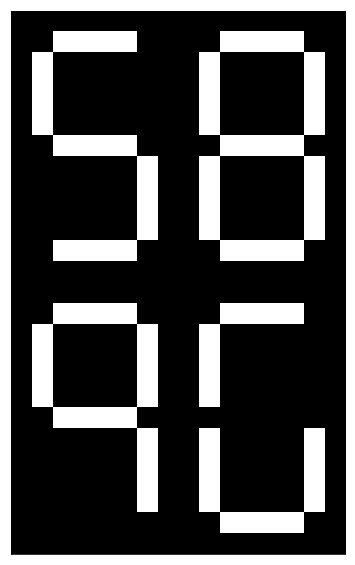

In [70]:
def generate_samples(n_samples, starting_image=None):

    samples = torch.from_numpy(
        starting_image if starting_image is not None else np.zeros((n_samples * n_samples, 1, image_width , image_height))).float()
    # set training to false
    cnn.train(False)
    
    # go over each pixel and predict the next one based on the previous
    for i in range(image_width):
        for j in range(image_height):
            with torch.no_grad():
                out = cnn(Variable(samples))
            probs = F.softmax(out[:, :, i, j], dim=1).data
#             print(out[:, :, i, j].shape, i, j, torch.multinomial(probs, 1).float())
            samples[:, :, i, j] = torch.multinomial(probs, 1).float()
    
    return samples.numpy()

samples = generate_samples(n_samples=2)
show_as_image(batch_images_to_one(samples), figsize=(10, 10))